In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from sklearn.model_selection import validation_curve
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
import warnings
import joblib as jb
warnings.filterwarnings('ignore')

In [2]:
import pickle

# Чтение датасета

In [3]:
df_start=pd.read_csv("ebw_data.csv")
df_start.head(5)

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


# Разведочный анализ и описательная статистика

In [4]:
df_start.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


In [5]:
df_start[["IW","IF","FP"]]=df_start[["IW","IF","FP"]].astype(float)
df_start.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     float64
 1   IF      72 non-null     float64
 2   VW      72 non-null     float64
 3   FP      72 non-null     float64
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(6)
memory usage: 3.5 KB


### Проверка на пропуски

In [6]:
df_start.isnull().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

In [7]:
df_start.describe()

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


### Количество уникальных значений в столбцах

In [8]:
df_start.nunique()

IW        7
IF        8
VW        5
FP        5
Depth    29
Width    25
dtype: int64

### Построим функцию для вывода графиков для анализа датасета а также функцию проверяющую нормальность распределения признаков датасета при помощи теста Шапиро

In [9]:
def diagnostic_plots (df, variable, title):
    fig, ax=plt.subplots(figsize=(10,7))
    #гистограмма
    plt.subplot (2,2,1)
    df[variable].hist(bins=30)
    #Q-Q plot
    plt.subplot(2,2,2)
    stats.probplot (df[variable], dist="norm", plot=plt)
    #скрипичная диаграмма 
    plt.subplot(2,2,3)
    sns.violinplot(x=df[variable])
    #ящик с усами
    plt.subplot(2,2,4)
    sns.boxplot(x=df[variable])
    fig.suptitle(title)
    plt.show

In [10]:
def test_shapiro (df, variable):
    stat, p=stats.shapiro(df[variable])
    print ("Statistics=%.3f,p-value=%3f"%(stat,p))
    alpha=0.05
    if p>alpha:
        print ("Нормальное распределение")
    else:
        print("Ненормальное распределение")

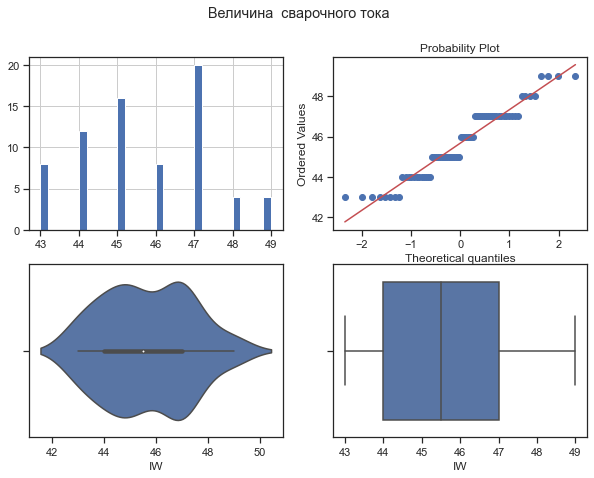

In [11]:
diagnostic_plots(df_start,"IW", "Величина  сварочного тока")

In [12]:
test_shapiro(df_start,"IW")

Statistics=0.932,p-value=0.000779
Ненормальное распределение


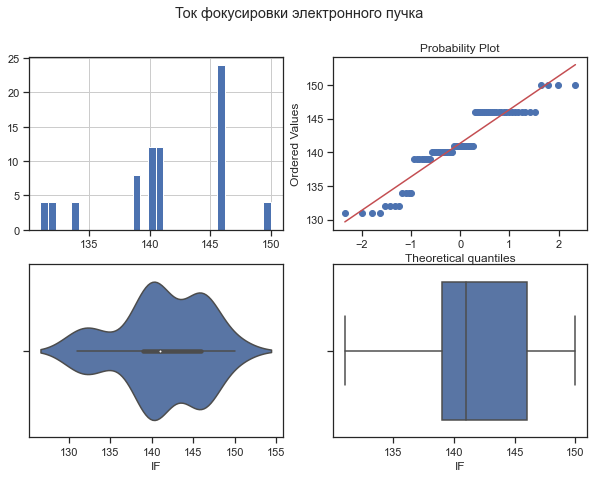

In [13]:
diagnostic_plots(df_start,"IF", "Ток фокусировки электронного пучка")

In [14]:
test_shapiro(df_start,"IF")

Statistics=0.896,p-value=0.000022
Ненормальное распределение


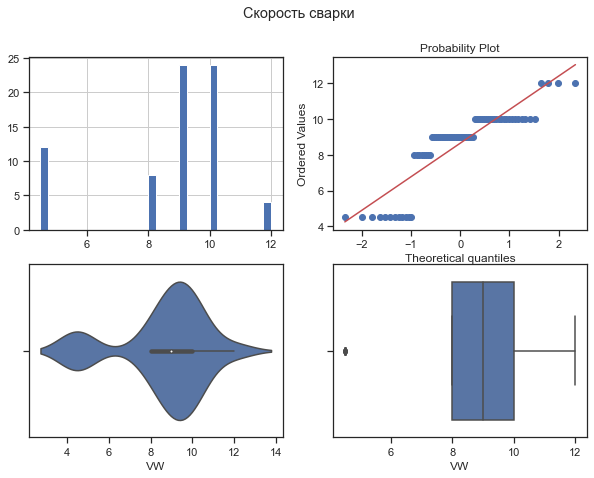

In [15]:
diagnostic_plots(df_start,"VW", "Скорость сварки")

In [16]:
test_shapiro(df_start,"VW")

Statistics=0.789,p-value=0.000000
Ненормальное распределение


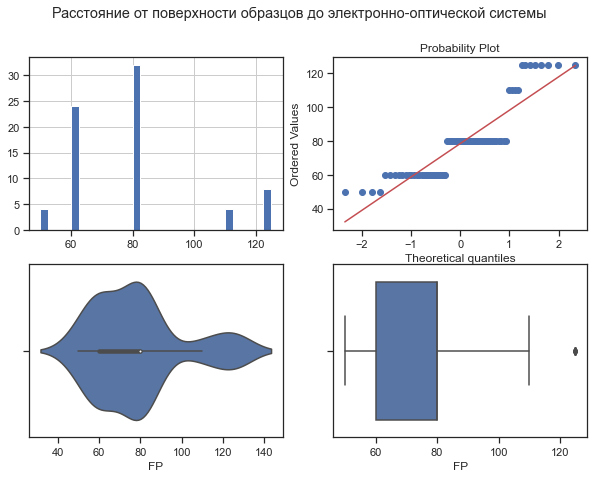

In [17]:
diagnostic_plots(df_start,"FP", "Расстояние от поверхности образцов до электронно-оптической системы")

In [133]:
test_shapiro(df_start,"FP")

Statistics=0.803,p-value=0.000000
Ненормальное распределение


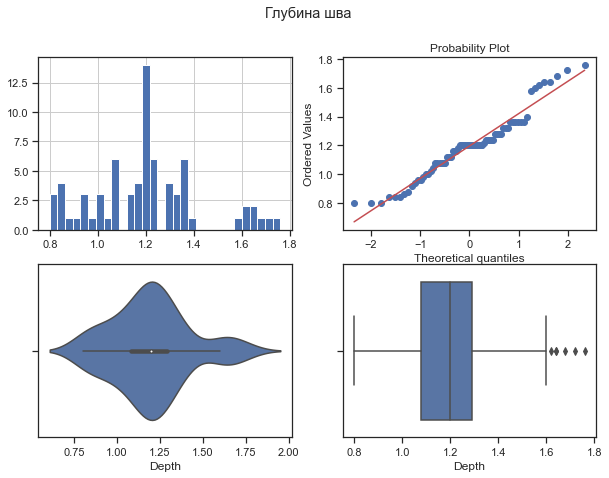

In [19]:
diagnostic_plots(df_start,"Depth", "Глубина шва")

In [20]:
test_shapiro(df_start,"Depth")

Statistics=0.951,p-value=0.006788
Ненормальное распределение


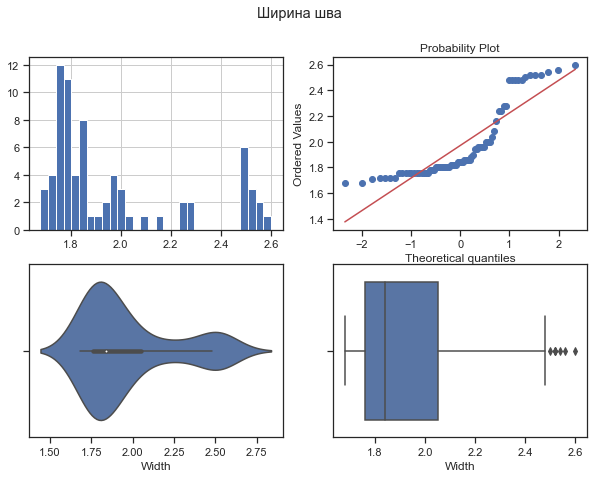

In [21]:
diagnostic_plots(df_start,"Width", "Ширина шва")

In [22]:
test_shapiro(df_start,"Width")

Statistics=0.786,p-value=0.000000
Ненормальное распределение


### Построим тепловую карту коэффициентов корреляции

Text(0.5, 1.0, 'Тепловая карта коэффициента корреляции')

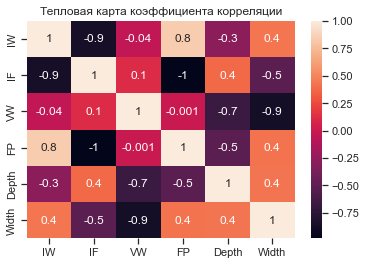

In [23]:
sns.heatmap(df_start.corr(), annot = True, fmt='.1g')
plt.title("Тепловая карта коэффициента корреляции")

# Выводы:

1. Датасет состоит из 72 строк и 6 столбцов: 2 столбца - целевые признаки, 4 - классификационные. Все признаки представляют собой количественные характеристики, кодирование не требуется. Так как целевых признаков два и корреляция между ними меньше 0,5 будем решать две задачи не учитывая зависимость между целевыми признаками. В датасете встречаются дубликаты данных, которые могут внести разлад в работу алгоритмов. Предполагаем, что дубликаты появились ввиду повторения ряда итераций для поиска отклонений величины глубины и ширины сварного шва при определенном режиме сварки. В связи с этим, а также ввиду малой размерности датасета, было принято решение дубли не удалять.
2. Данные представляют собой вещественные и натуральные числа. Приведены к одному типу данных.
3. Данные не подчиняются нормальному распределению. Перед подачей в обучаемую модель необходимо провести стандартизацию данных.
4. В датасете отсутствуют пропуски.
5. По графикам ***\"ящик с усами\"*** видно, что в признаках **"Скорость сварки"**, **"Расстояние от поверхности образцов до электронно-оптической системы"**, **"Глубина шва"** и **"Ширина шва"** присутствуют выбросы. В данном примере не будем удалять выбросы в связи с малой размерностью датасета и отсутствием понимания, действительно ли данные значения являются выбросами или же эти значения обусловленны с точки зрения технологии сварки.
6. Данная задача является задачей регрессии. На вход подаются вещественные значения, на выходе мы также получим число. Исходя из этого решаем задачу методами регрессионного анализа.
7. С учетом того, что парметр **"Ток фокусировки электронного пучка**" очень сильно корррелирует с параметрами **"Расстояние от поверхности образцов до электронно-оптической системы"** и **"Скорость сварки"** для исключения переобучения модели данные параметры при формировании датафрейма для решения задачи определения ширины шва можно исключить. Набор ключевых признаков для датафрейма поиска ширины шва - **"Ток фокусировки электронного пучка"** и **"Скорость сварки"**. В свою очередь, набор ключевых признаков для формирования датафрейма поиска глубины шва - **"Скорость сварки"**, **"Ток фокусировки электронного пучка"** и **"Величина сварочного тока"**. 

# Разделим датасет согласно выводам на два датафрейма и проведем стандартизацию

### Ширина

In [24]:
s_target_width=["Width"]
s_influencing_width=["IF","VW"]

In [25]:
y_width=df_start.loc[:,s_target_width]
x_width=df_start.loc[:,s_influencing_width]

### Глубина

In [26]:
s_target_depth=["Depth"]
s_influencing_depth=["IW","VW","IF"]

In [27]:
y_depth=df_start.loc[:,s_target_depth]
x_depth=df_start.loc[:,s_influencing_depth]

### Препроцессинг

In [28]:
s_influencing_transformer_width=Pipeline(steps=[
    ("scaler",StandardScaler())])
prp_width=ColumnTransformer(transformers=[("num",s_influencing_transformer_width,s_influencing_width)])
clf_width=Pipeline(steps=[("prp",prp_width)])

In [29]:
s_influencing_transformer_depth=Pipeline(steps=[
    ("scaler",StandardScaler())])
prp_depth=ColumnTransformer(transformers=[("num",s_influencing_transformer_depth,s_influencing_depth)])
clf_depth=Pipeline(steps=[("prp",prp_depth)])

### Функция кросс-валидации

In [30]:
RS=42

In [31]:
def run_cv_for_models(models, x, y):
    stat = pd.DataFrame()
    cv = KFold(3, shuffle=True, random_state=RS)
    scoring = ["r2", 
                "neg_root_mean_squared_error"]
    for model_name, model in models.items():
        scores = cross_validate(model, x, y, cv=cv, scoring=scoring)
        stat.loc[model_name, "R2"] = scores["test_r2"].mean()
        stat.loc[model_name, "RMSE"] = scores["test_neg_root_mean_squared_error"].mean()
    return stat

### Функция сетки поиска для подбора гипперпараметров

In [32]:
def run_grid_search_optimiser(model, params, x, y):
    pd.options.display.max_colwidth = 150
    stat = pd.DataFrame()
    cv = KFold(3, shuffle=True, random_state=RS)
    # scoring = 'neg_root_mean_squared_error'
    scoring = "neg_root_mean_squared_error"
    searcher = GridSearchCV(model, params, cv=cv, scoring=scoring)
    searcher.fit(x, y)
    stat.loc[:, "params"] = searcher.cv_results_["params"]
    stat.loc[:, "RMSE"] = searcher.cv_results_["mean_test_score"]
   # stat.loc[:, "rank"] = searcher.cv_results_["rank_test_score"]
    return stat, searcher.best_estimator_,searcher.best_params_

### Функция вывода метрик для сравнения

In [33]:
def analitics(base_model, opt_model, y_test, y_predict_base,y_predict_opt):
    count_base_r2=metrics.r2_score(y_test, y_predict_base)
    count_opt_r2=metrics.r2_score(y_test, y_predict_opt)
    count_base_rmse=metrics.mean_squared_error(y_test, y_predict_base)*-1
    count_opt_rmse=metrics.mean_squared_error(y_test, y_predict_opt)*-1
    dict_stat={
        "R2":pd.Series([count_base_r2,count_opt_r2],index=[base_model,opt_model]),
        "RMSE":pd.Series([count_base_rmse,count_opt_rmse],index=[base_model,opt_model])
    }
    df_stat=pd.DataFrame(dict_stat)
    return df_stat.style.highlight_max(axis=0)

### Функция построения графика проверки на переобучение

In [34]:
def val_curve(train_score,test_score,model,param_name):
    mean_train_score = np.mean(train_score, axis = 1)
    std_train_score = np.std(train_score, axis = 1)
    mean_test_score = np.mean(test_score, axis = 1)
    std_test_score = np.std(test_score, axis = 1)
    plt.plot(parameter_range, mean_train_score,
        label = "Training Score", color = 'b')
    plt.plot(parameter_range, mean_test_score,
        label = "Validation Score", color = 'g')
    plt.title(model)
    plt.xlabel(param_name)
    plt.ylabel("R2 metrics")
    plt.tight_layout()
    plt.legend(loc = 'best')
    plt.show()

# Решение первой задачи - ширина

## Алгоритмы из библиотеки SKlearn

### Разделение выборки

In [35]:
x_train_to_prp_width,x_test_to_prp_width,y_train_to_prp_width,y_test_to_prp_width=train_test_split(x_width,y_width,test_size=0.1,random_state=RS)

In [36]:
x_train_width=clf_width.fit_transform(x_train_to_prp_width)
x_test_width=clf_width.transform(x_test_to_prp_width)

In [37]:
y_train_width=y_train_to_prp_width["Width"].values
y_test_width=y_test_to_prp_width["Width"].values

### Сравнение метрик моделей с дефолтными гипперпараметрами

In [38]:
dict_models_width = {
    "DummyRegressor": DummyRegressor(strategy="mean"),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "SVR": SVR(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=RS),
    "RandomForestRegressor": RandomForestRegressor(random_state=RS)
}

stat_width = run_cv_for_models(dict_models_width, x_train_width, y_train_width)
stat_width.style.highlight_max(axis=0)

,R2,RMSE
DummyRegressor,-0.047188,-0.263312
Ridge,0.891438,-0.080657
Lasso,-0.047188,-0.263312
SVR,0.880143,-0.083962
KNeighborsRegressor,0.832729,-0.104455
DecisionTreeRegressor,0.548956,-0.169723
RandomForestRegressor,0.742434,-0.129595


### Подбор гипперпараметров

In [39]:
dict_search_model_width={}

#### ***Ridge***

In [40]:
params_width = [
  {
    "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga", "lbfgs"],
    "alpha": np.linspace(0.001, 5, 200)
  },           
  {
    "solver": ["lbfgs"],
    "alpha": np.linspace(0.001, 5, 200),
    "positive": [True]
  }
]
search, search_option_model,best_params = run_grid_search_optimiser(Ridge(), params_width, x_train_width, y_train_width)
dict_search_model_width[str(search_option_model)] = search_option_model
best_params

{'alpha': 0.001, 'solver': 'sag'}

#### ***Lasso***

In [41]:
params_width = {
    "alpha": np.linspace(0.001, 5, 200)
  }
search, search_option_model,best_params = run_grid_search_optimiser(Lasso(), params_width, x_train_width, y_train_width)
dict_search_model_width[str(search_option_model)] = search_option_model
best_params

{'alpha': 0.001}

#### ***SVR***

In [42]:
params_width = [       
    {
      "kernel": ["linear"],
      "C": np.linspace(0.001, 5, 200)
    },
    {
      "kernel": ["poly"],
      "C": np.linspace(0.001, 5, 200)
    },
    {
      "kernel": ["rbf"],
      "C": np.linspace(0.001, 5, 200)
    },
    {
      "kernel": ["sigmoid"],
      "C": np.linspace(0.001, 5, 200)
    }
]
search, search_option_model,best_params = run_grid_search_optimiser(SVR(), params_width, x_train_width, y_train_width)
dict_search_model_width[str(search_option_model)] = search_option_model
best_params

{'C': 3.8444522613065324, 'kernel': 'poly'}

#### ***KNeighborsRegressor***

In [43]:
params_width = {
      "n_neighbors": range(1, 21, 2)
    }
search, search_option_model,best_params = run_grid_search_optimiser(KNeighborsRegressor(), params_width, x_train_width, y_train_width)
dict_search_model_width[str(search_option_model)] = search_option_model
best_params

{'n_neighbors': 3}

#### ***DecisionTreeRegressor***

In [44]:
params_width = {
    "random_state": [RS],
    "max_depth": range(1, 11, 1),
    "min_samples_split": range(2, 5, 1),
    "min_samples_leaf": range(2, 5, 1),
}
search, search_option_model,best_params = run_grid_search_optimiser(DecisionTreeRegressor(), params_width, x_train_width, y_train_width)
dict_search_model_width[str(search_option_model)] = search_option_model
best_params

{'max_depth': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'random_state': 42}

#### ***RandomForestRegressor***

In [45]:
params_width = {
    "random_state": [RS],
    "n_estimators": range(50, 100, 10),
    "max_depth": range(1, 11, 1),
    "min_samples_split": range(2, 5, 1),
    "min_samples_leaf": range(2, 5, 1),
}
search, search_option_model,best_params = run_grid_search_optimiser(RandomForestRegressor(), params_width, x_train_width, y_train_width)
dict_search_model_width[str(search_option_model)] = search_option_model
best_params

{'max_depth': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 90,
 'random_state': 42}

In [46]:
stat_width = run_cv_for_models(dict_search_model_width, x_train_width, y_train_width)
stat_width.style.highlight_max(axis=0)

,R2,RMSE
"Ridge(alpha=0.001, solver='sag')",0.890953,-0.079837
Lasso(alpha=0.001),0.891146,-0.079997
"SVR(C=3.8444522613065324, kernel='poly')",0.892201,-0.078314
KNeighborsRegressor(n_neighbors=3),0.894561,-0.072117
"DecisionTreeRegressor(max_depth=6, min_samples_leaf=2, random_state=42)",0.546524,-0.169849
"RandomForestRegressor(max_depth=7, min_samples_leaf=2, n_estimators=90, random_state=42)",0.676658,-0.144400


### Предсказание лучшей модели с дефолтными параметрами

In [47]:
best_model_base_params_width=Ridge()
best_model_base_params_width.fit(x_train_width,y_train_width)
y_predict_base_width=best_model_base_params_width.predict(x_test_width)

### Предсказание лучшей модели с подобранными гипперпараметрами

In [48]:
best_model_optimal_params_width=KNeighborsRegressor(n_neighbors=3)
best_model_optimal_params_width.fit(x_train_width,y_train_width)
y_predict_optimal_width=best_model_optimal_params_width.predict(x_test_width)

### Сравнение точности предсказания лучшей модели с дефолтными гипперпараметрами с лучшей моделью с подобранными гипперпараметрами по метрикам

In [49]:
analitics(best_model_base_params_width,best_model_optimal_params_width,y_test_width,y_predict_base_width,y_predict_optimal_width)

,R2,RMSE
Ridge(),0.956554,-0.004536
KNeighborsRegressor(n_neighbors=3),0.978023,-0.002294


### Проверка на переобучение

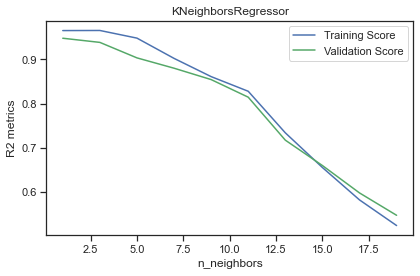

In [50]:
parameter_range = range(1, 21, 2)
train_score, test_score = validation_curve(KNeighborsRegressor(), x_train_width, y_train_width,
                                       param_name = "n_neighbors",
                                       param_range = parameter_range,
                                        cv = 3, scoring = "r2")
val_curve(train_score,test_score,"KNeighborsRegressor","n_neighbors")

#### Исходя из графика делаем вывод, что модель не переобучена

## Нейросеть

### Размерность входа

In [51]:
n_influencing_width=x_train_width.shape[1]

### Архитектура НС

In [52]:
model_nn_width=Sequential()
model_nn_width.add(Dense(128,activation="relu",input_shape=(n_influencing_width,)))
model_nn_width.add(Dense(1,activation="relu"))


### Компиляция модели

In [53]:
model_nn_width.compile(optimizer="adam",loss="mean_squared_error",metrics=[tf.keras.metrics.RootMeanSquaredError()])

### Обучение

Epoch 1/50
8/8 [==============================] - 0s 18ms/step - loss: 3.8059 - root_mean_squared_error: 1.9509 - val_loss: 4.0630 - val_root_mean_squared_error: 2.0157
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 3.5886 - root_mean_squared_error: 1.8944 - val_loss: 3.6271 - val_root_mean_squared_error: 1.9045
Epoch 3/50
8/8 [==============================] - 0s 3ms/step - loss: 3.3615 - root_mean_squared_error: 1.8334 - val_loss: 3.1602 - val_root_mean_squared_error: 1.7777
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 3.0658 - root_mean_squared_error: 1.7509 - val_loss: 2.6919 - val_root_mean_squared_error: 1.6407
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 2.7852 - root_mean_squared_error: 1.6689 - val_loss: 2.2680 - val_root_mean_squared_error: 1.5060
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 2.4881 - root_mean_squared_error: 1.5774 - val_loss: 1.8571 - val_root_mean_squared_error

8/8 [==============================] - 0s 3ms/step - loss: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1030
Epoch 50/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0114 - root_mean_squared_error: 0.1069 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1013


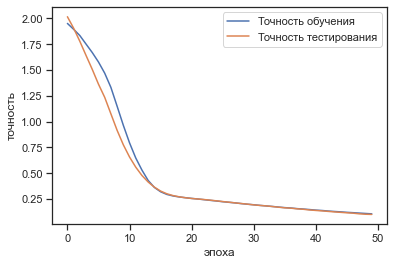

In [54]:
history=model_nn_width.fit(x_train_width,y_train_width,
                 epochs=50,
                 batch_size=8,
                 verbose=1,
                 validation_data=(x_test_width,y_test_width))
plt.plot(history.history["root_mean_squared_error"],
        label="Точность обучения")
plt.plot(history.history["val_root_mean_squared_error"],
        label="Точность тестирования")
plt.xlabel("эпоха")
plt.ylabel("точность")
plt.legend()
plt.show()

### Предсказание нейросети

In [55]:
y_predict_nn_width=model_nn_width.predict(x_test_width)

1/1 [==============================] - 0s 56ms/step


In [56]:
model_nn_width.evaluate(x_test_width,y_test_width, return_dict=True)

1/1 [==============================] - 0s 70ms/step - loss: 0.0103 - root_mean_squared_error: 0.1013


{'loss': 0.01025856751948595, 'root_mean_squared_error': 0.10128458589315414}

### Сравнение точности предсказания лучшей модели  с подобранными гипперпараметрами с предсказанием нейросети

In [57]:
analitics(best_model_optimal_params_width,"Neural network",y_test_width,y_predict_optimal_width,y_predict_nn_width)

,R2,RMSE
KNeighborsRegressor(n_neighbors=3),0.978023,-0.002294
Neural network,0.901738,-0.010259


# Решение второй задачи - глубина

## Алгоритмы из библиотеки SKlearn

### Выборка

In [58]:
x_train_to_prp_depth,x_test_to_prp_depth,y_train_to_prp_depth,y_test_to_prp_depth=train_test_split(x_depth,y_depth,test_size=0.1,random_state=RS)

In [59]:
x_train_depth=clf_depth.fit_transform(x_train_to_prp_depth)
x_test_depth=clf_depth.transform(x_test_to_prp_depth)

In [60]:
y_train_depth=y_train_to_prp_depth["Depth"].values
y_test_depth=y_test_to_prp_depth["Depth"].values

### Сравнение метрик моделей с дефолтными параметрами

In [61]:
dict_models_depth = {
    "DummyRegressor": DummyRegressor(strategy="mean"),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "SVR": SVR(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=RS),
    "RandomForestRegressor": RandomForestRegressor(random_state=RS)
}

stat_depth = run_cv_for_models(dict_models_depth, x_train_depth, y_train_depth)
stat_depth.style.highlight_max(axis=0)

,R2,RMSE
DummyRegressor,-0.272412,-0.227883
Ridge,0.493701,-0.143741
Lasso,-0.272412,-0.227883
SVR,0.739224,-0.103205
KNeighborsRegressor,0.779870,-0.094616
DecisionTreeRegressor,0.630564,-0.117695
RandomForestRegressor,0.798752,-0.089856


### Подбор гипперпараметров

In [62]:
dict_search_model_depth={}

#### ***Ridge***

In [63]:
params_depth = [
  {
    "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga", "lbfgs"],
    "alpha": np.linspace(0.001, 5, 200)
  },           
  {
    "solver": ["lbfgs"],
    "alpha": np.linspace(0.001, 5, 200),
    "positive": [True]
  }
]
search, search_option_model,best_params = run_grid_search_optimiser(Ridge(), params_depth, x_train_depth, y_train_depth)
dict_search_model_depth[str(search_option_model)] = search_option_model
best_params

{'alpha': 0.17684422110552764, 'solver': 'sag'}

#### ***Lasso***

In [64]:
params_depth = {
    "alpha": np.linspace(0.001, 5, 200)
  }
search, search_option_model,best_params = run_grid_search_optimiser(Lasso(), params_depth, x_train_depth, y_train_depth)
dict_search_model_depth[str(search_option_model)] = search_option_model
best_params

{'alpha': 0.001}

#### ***SVR***

In [65]:
params_depth = [       
    {
      "kernel": ["linear"],
      "C": np.linspace(0.001, 5, 200)
    },
    {
      "kernel": ["poly"],
      "C": np.linspace(0.001, 5, 200)
    },
    {
      "kernel": ["rbf"],
      "C": np.linspace(0.001, 5, 200)
    },
    {
      "kernel": ["sigmoid"],
      "C": np.linspace(0.001, 5, 200)
    }
]
search, search_option_model,best_params = run_grid_search_optimiser(SVR(), params_depth, x_train_depth, y_train_depth)
dict_search_model_depth[str(search_option_model)] = search_option_model
best_params

{'C': 0.3778090452261307, 'kernel': 'rbf'}

#### ***KNeighborsRegressor***

In [66]:
params_depth = {
      "n_neighbors": range(1, 21, 2)
    }
search, search_option_model,best_params = run_grid_search_optimiser(KNeighborsRegressor(), params_depth, x_train_depth, y_train_depth)
dict_search_model_depth[str(search_option_model)] = search_option_model
best_params

{'n_neighbors': 3}

#### ***DecisionTreeRegressor***

In [67]:
params_depth = {
    "random_state": [RS],
    "max_depth": range(1, 11, 1),
    "min_samples_split": range(2, 5, 1),
    "min_samples_leaf": range(2, 5, 1),
}
search, search_option_model,best_params = run_grid_search_optimiser(DecisionTreeRegressor(), params_depth, x_train_depth, y_train_depth)
dict_search_model_depth[str(search_option_model)] = search_option_model
best_params

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'random_state': 42}

#### ***RandomForestRegressor***

In [68]:
params_depth = {
    "random_state": [RS],
    "n_estimators": range(50, 100, 10),
    "max_depth": range(1, 11, 1),
    "min_samples_split": range(2, 5, 1),
    "min_samples_leaf": range(2, 5, 1),
}
search, search_option_model,best_params = run_grid_search_optimiser(RandomForestRegressor(), params_depth, x_train_depth, y_train_depth)
dict_search_model_depth[str(search_option_model)] = search_option_model
best_params

{'max_depth': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 70,
 'random_state': 42}

In [69]:
stat_depth = run_cv_for_models(dict_search_model_depth, x_train_depth, y_train_depth)
stat_depth.style.highlight_max(axis=0)

,R2,RMSE
"Ridge(alpha=0.17684422110552764, solver='sag')",0.498686,-0.143092
Lasso(alpha=0.001),0.496550,-0.143385
SVR(C=0.3778090452261307),0.740406,-0.102974
KNeighborsRegressor(n_neighbors=3),0.768051,-0.094600
"DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, random_state=42)",0.805371,-0.086152
"RandomForestRegressor(max_depth=6, min_samples_leaf=2, n_estimators=70, random_state=42)",0.800397,-0.089752


### Предсказание лучшей модели с дефолтными параметрами

In [70]:
best_model_base_params_depth=RandomForestRegressor(random_state=RS)
best_model_base_params_depth.fit(x_train_depth,y_train_depth)
y_predict_base_depth=best_model_base_params_depth.predict(x_test_depth)

### Предсказание лучшей модели с подобранными гипперпараметрами

In [71]:
best_model_optimal_params_depth=DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, random_state=42)
best_model_optimal_params_depth.fit(x_train_depth,y_train_depth)
y_predict_optimal_depth=best_model_optimal_params_depth.predict(x_test_depth)

### Сравнение точности предсказания лучшей модели с дефолтными гипперпараметрами с лучшей моделью с подобранными гипперпараметрами по метрикам

In [74]:
analitics(best_model_base_params_depth,best_model_optimal_params_depth,y_test_depth,y_predict_base_depth,y_predict_optimal_depth)

,R2,RMSE
RandomForestRegressor(random_state=42),0.904070,-0.006293
"DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, random_state=42)",0.905801,-0.006179


### Проверка на переобучение

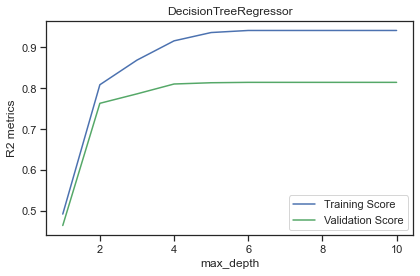

In [75]:
parameter_range = range(1, 11, 1)
train_score, test_score = validation_curve(DecisionTreeRegressor(), x_train_depth, y_train_depth,
                                       param_name = "max_depth",
                                       param_range = parameter_range,
                                        cv = 3, scoring = "r2")
val_curve(train_score,test_score,"DecisionTreeRegressor","max_depth")

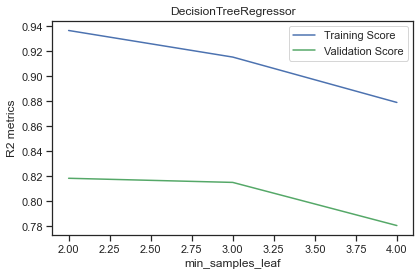

In [76]:
parameter_range = range(2, 5, 1)
train_score, test_score = validation_curve(DecisionTreeRegressor(), x_train_depth, y_train_depth,
                                       param_name = "min_samples_leaf",
                                       param_range = parameter_range,
                                        cv = 3, scoring = "r2")
val_curve(train_score,test_score,"DecisionTreeRegressor","min_samples_leaf")

#### Исходя из графиков делаем вывод, что модель не переобучена

## Нейросеть

### Размерность входа

In [77]:
n_influencing_depth=x_train_depth.shape[1]

### Архитектура НС

In [78]:
model_nn_depth=Sequential()
model_nn_depth.add(Dense(128,activation="relu",input_shape=(n_influencing_depth,)))
model_nn_depth.add(Dense(1,activation="relu"))

### Компиляция модели

In [79]:
model_nn_depth.compile(optimizer="adam",loss="mean_squared_error",metrics=[tf.keras.metrics.RootMeanSquaredError()])

### Обучение

Epoch 1/50
8/8 [==============================] - 0s 14ms/step - loss: 0.9859 - root_mean_squared_error: 0.9929 - val_loss: 1.0661 - val_root_mean_squared_error: 1.0325
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6636 - root_mean_squared_error: 0.8146 - val_loss: 0.7083 - val_root_mean_squared_error: 0.8416
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4499 - root_mean_squared_error: 0.6707 - val_loss: 0.4508 - val_root_mean_squared_error: 0.6715
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 0.2918 - root_mean_squared_error: 0.5402 - val_loss: 0.2878 - val_root_mean_squared_error: 0.5365
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 0.1975 - root_mean_squared_error: 0.4445 - val_loss: 0.1851 - val_root_mean_squared_error: 0.4303
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 0.1445 - root_mean_squared_error: 0.3801 - val_loss: 0.1276 - val_root_mean_squared_error

8/8 [==============================] - 0s 3ms/step - loss: 0.0088 - root_mean_squared_error: 0.0939 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1003
Epoch 50/50
8/8 [==============================] - 0s 3ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007


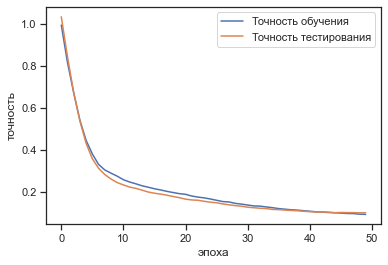

In [80]:
history=model_nn_depth.fit(x_train_depth,y_train_depth,
                 epochs=50,
                 batch_size=8,
                 verbose=1,
                 validation_data=(x_test_depth,y_test_depth))
plt.plot(history.history["root_mean_squared_error"],
        label="Точность обучения")
plt.plot(history.history["val_root_mean_squared_error"],
        label="Точность тестирования")
plt.xlabel("эпоха")
plt.ylabel("точность")
plt.legend()
plt.show()

### Предсказание нейросети

In [81]:
y_predict_nn_depth=model_nn_depth.predict(x_test_depth)

1/1 [==============================] - 0s 34ms/step


In [82]:
model_nn_depth.evaluate(x_test_depth,y_test_depth, return_dict=True)

1/1 [==============================] - 0s 70ms/step - loss: 0.0101 - root_mean_squared_error: 0.1007


{'loss': 0.010146383196115494, 'root_mean_squared_error': 0.10072925686836243}

### Сравнение точности предсказания лучшей модели  с подобранными гипперпараметрами с предсказанием нейросети

In [83]:
analitics(best_model_optimal_params_depth,"Neural network",y_test_depth,y_predict_optimal_depth,y_predict_nn_depth)

,R2,RMSE
"DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, random_state=42)",0.905801,-0.006179
Neural network,0.845330,-0.010146


# Выводы по работе

По результатам проделанной работы получены следующие выводы:
1. Данная задача - задача регрессии с поиском двух целевых параметров: глубины и ширины;
2. Датасет довольно маленький, без пропусков, выбросы в рамках данной предметной области принято считать "живыми" результатами эксперимента при заданных параметрах классификационных признаков;
3. Для решения задачи поиска ширины лучше всего себя показала модель **"К ближайших соседей"** с ***3*** случайными соседями. Модель не переобучена, дает довольно высокий показатель метрики ***R2***. Нейросеть показала себя также довольно неплохо, однако ее метрики хуже метрик оптимального алгоритма
4. Для решения задачи поиска длины лучше всего себя показала модель **"Дерево решений"** с максимальной глубиной дерева ***5*** и минимальным количеством образцов ***2***. Модель не переобучена, дает довольно высокий показатель метрики R2. Нейросеть показала себя также довольно неплохо, однако ее метрики хуже метрик оптимального алгоритма

# Сохранение параметров для передачи их в приложение

In [84]:
pickle.dump(best_model_optimal_params_width,open("KNN_model_for_width.pkl","wb"))

In [85]:
pickle.dump(best_model_optimal_params_depth,open("DTR_model_for_depth.pkl","wb"))

In [86]:
scaler_filename = "scaler_width.save"
jb.dump(clf_width, scaler_filename) 

['scaler_width.save']

In [87]:
scaler_filename = "scaler_depth.save"
jb.dump(clf_depth, scaler_filename) 

['scaler_depth.save']

# Проверка чтения модели

In [88]:
model_load_width=pickle.load(open("KNN_model_for_width.pkl","rb"))

In [90]:
model_load_depth=pickle.load(open("DTR_model_for_depth.pkl","rb"))

In [91]:
model_load_width.predict(x_test_width)

array([2.52      , 1.78666667, 1.80666667, 2.52      , 2.52      ,
       1.78666667, 1.97333333, 2.09333333])

In [96]:
model_load_depth.predict(x_test_depth)

array([1.66666667, 1.22857143, 1.12      , 1.5       , 1.5       ,
       1.22857143, 1.2       , 0.83333333])

# Проверочные тесты для приложения

#### Функция предобработки ввода

In [97]:
def predict_transform (params,columns,clf):
    list_reshape=np.array(params).reshape(1,len(params))
    x_predict=pd.DataFrame(list_reshape,columns=columns)
    x_predict_clf=clf.transform(x_predict)
    return x_predict_clf

#### Тест 1

In [99]:
params_width_1=[141,10]
params_depth_1=[46,10,141]
columns_width_1=["IF","VW",]
columns_depth_1=["IW","VW","IF"]
y_predict_width_ex1=best_model_optimal_params_width.predict(predict_transform (params_width_1,columns_width_1,clf_width))
y_predict_depth_ex1=best_model_optimal_params_depth.predict(predict_transform (params_depth_1,columns_depth_1,clf_depth))

In [100]:
y_predict_width_ex1

array([1.80666667])

In [101]:
y_predict_depth_ex1

array([1.12])

#### Тест 2

In [124]:
params_width_2=[140,5]
params_depth_2=[45,5,140]
columns_width_2=["IF","VW",]
columns_depth_2=["IW","VW","IF"]
y_predict_width_ex2=best_model_optimal_params_width.predict(predict_transform (params_width_2,columns_width_2,clf_width))
y_predict_depth_ex2=best_model_optimal_params_depth.predict(predict_transform (params_depth_2,columns_depth_2,clf_depth))

In [125]:
y_predict_width_ex2

array([2.52])

In [126]:
y_predict_depth_ex2

array([1.66666667])

#### Тест 3

In [130]:
params_width_3=[180,15]
params_depth_3=[48,15,180]
columns_width_3=["IF","VW",]
columns_depth_3=["IW","VW","IF"]
y_predict_width_ex3=best_model_optimal_params_width.predict(predict_transform (params_width_3,columns_width_3,clf_width))
y_predict_depth_ex3=best_model_optimal_params_depth.predict(predict_transform (params_depth_3,columns_depth_3,clf_depth))

In [131]:
y_predict_width_ex3

array([1.81333333])

In [132]:
y_predict_depth_ex3

array([1.08])